# Detecting Spots of Color

In this notebook, a PiCamera is required.

The user sets a target color (*`target_color` is a tuple describing an RGB color*) and then the algorithm tries to identify the location in the image that's the closest in terms of color to the one the user has set as a target. If the detected color represents more than 7% (*this 7% is represented by `color_threshold` variable*) of the entire image, then a contour with a green border is drawn around it.

This is a color detection system that can be subsequently turned into an object detection system.

Expect this to work at 4-5 FPS.

Now let's import the required modules.

In [1]:
import time
import picamera
import numpy as np
import threading
import queue
import io
import IPython
from PIL import Image
from sklearn.cluster import KMeans

Next up we define 2 functions:

* `showarray` - Used for showing a continuous stream of jpeg images.
* `resizeNPArray` - Used for resizing a numpy array to another width/height by first converting it to an image and then putting it back into a numpy array.

In [2]:
# Use 'jpeg' instead of 'png' (~5 times faster)
def showarray(a, fmt='jpeg'):
    '''
    Function to display an image within a Jupyter notebook.
    '''
    f = io.BytesIO()
    Image.fromarray(a).save(f, fmt)
    IPython.display.display(IPython.display.Image(data=f.getvalue(), width = 480, height = 360))

def resizeNPArray(array, width, height):
    '''
    Function to resize a given numpy array to another width/height,
    whilst preserving the relative information - used for images.
    '''
    img = Image.fromarray(array)
    img = img.resize((width, height), Image.ANTIALIAS)
    resized = np.asarray(img)
    return resized

This `ImageProcessor` class can be subsequently used for processing streams on multiple cores at the same time. 

For the time being, it's only used to process the queue of images that gets filled in the main thread with PiCamera.

Now, the question is, how does this algorithm work?

Each image is downsized a lot (from 320x240 pixels to 80x60 pixels) and then a KMeans algorithm is ran through. The data that is fed to KMeans has 5 dimensions:
* 3 dimensions for the RGB color.
* 2 dimensions for the position of the pixel in the image.

By using another 2 dimensions in KMeans algorithm, we avoid having the labels of a color center appear in multiple locations of the image that have no link between said zones. The advantage is that this way, labels for a given color center will tend to clusterize together. The farther a potential candidate is from the cluster (of color center), the less likely it will get selected to be in the pool of those labels.

Take this example: say there are 2 spots of white color in an image. By using only 3 dimensions with KMeans, we'd get the same labels for both zones of color. But if we are to use the extra 2 dimensions, there can no longer be 2 zones - the tendency to only have a single cluster of labels of the same kind gets to be big and helps at detecting the dominant zone where the color is the strongest (and has the largest size).

In [3]:
class ImageProcessor(threading.Thread):
    '''
    Thread-safe class to process a stream of jpeg sequences from a given queue.
    '''
    def __init__(self, thread_stopper, frames, lock):
        '''
        thread_stopper -> Is the event which stops the thread when set.
        frames -> The queue from which jpeg images come (in numpy.array format).
        lock -> Mutex for the queue.
        '''
        super().__init__()
        self.thread_stopper = thread_stopper
        self.frames = frames
        self.lock = lock
        self.incoming = np.empty((240, 320, 3), dtype = np.uint8)
        self.processed = np.zeros((240, 320, 3), dtype = np.uint8)
        
        self.verticals = np.array(80 * [np.arange(0, 60)]).T
        self.verticals = self.verticals[:,:,np.newaxis]
        
        self.horizontals = np.array(60 * [np.arange(0, 80)])
        self.horizontals = self.horizontals[:,:,np.newaxis]
        
    def run(self):
        '''
        Main thread which runs indefinitely until <<thread_stopper>> event is set.
        This function processes each incoming image from the queue iteratively and then displays it in this notebook.
        '''
        while not thread_stopper.is_set():
            try:
                self.lock.acquire()
                self.incoming = self.frames.get_nowait()
                self.position, self.processed = self.dowork(self.incoming)
                self.frames.task_done()
            except queue.Empty:
                continue
            finally:
                self.lock.release()
            showarray(self.processed)
            IPython.display.clear_output(wait = True)
            
    def dowork(self, array):
        '''
        array -> Is a numpy array that holds the a RGB image.
        Function to process an image and detect spots of a given targeted color.
        '''
        
        # down-sizing the image and running KMeans on it
        output = array.copy()
        array = resizeNPArray(array, 80, 60)
        image_and_positions = np.concatenate((array, self.verticals, self.horizontals), axis = 2)
        reshaped = image_and_positions.reshape((60 * 80, 5))
        kmeans = KMeans(n_clusters = 6,
                       n_init = 1,
                       max_iter = 300,
                       precompute_distances = True).fit(reshaped)
        rgb_centers = kmeans.cluster_centers_[:, 0:3]
        
        labels_rgb = np.empty((4800, 3))
        for i in range(6):
            labels_rgb[kmeans.labels_ == i] = rgb_centers[i]
        labels_rgb = labels_rgb.reshape((60, 80, 3)).astype(np.uint8)
        
        # getting the closest KMeans center to the targeted color
        diff = rgb_centers - target_color
        closest = np.sqrt(np.power(diff, 2).sum(axis = 1))
        closest_label = closest.argmin()
        
        # determining the distribution of the targeted pixels
        # (the target pixels are identified with the label of the selected KMeans center)
        labels = kmeans.labels_.reshape((60, 80))
        labels = labels == closest_label
        sum_labels_vertical = labels.sum(axis = 1)
        sum_labels_horizontal = labels.sum(axis = 0)
        
        # 4800 = 60 * 80 pixels
        if not sum_labels_vertical.sum() > color_threshold * 4800:
            return (None, output)
        
        # find the countour of the spot of color
        non_zero_elements = np.nonzero(sum_labels_vertical)
        # multiply by 4 to get to the original size
        min_vertical = np.min(non_zero_elements) * 4
        max_vertical = np.max(non_zero_elements) * 4
        non_zero_elements = np.nonzero(sum_labels_horizontal)
        min_horizontal = np.min(non_zero_elements) * 4
        max_horizontal = np.max(non_zero_elements) * 4
        
        # and then draw a rectangle around the detected spot of color
        output[min_vertical:max_vertical+1,min_horizontal,:] = border_color
        output[min_vertical:max_vertical+1,max_horizontal,:] = border_color
        output[min_vertical,min_horizontal:max_horizontal+1,:] = border_color
        output[max_vertical,min_horizontal:max_horizontal+1,:] = border_color
        
        center_position = (min_vertical + max_vertical) / 2
                
        return (center_position, output)

This is where everything gets instantiated and started.
1. `target_color` represents the color we want to detect in the image. It works best with white.
1. `border_color` represents the color of the border that surrounds a spot of color when detected.
1. `color_threshold` represents the threshold percentage of the occupied space (per total space of the entire image) of the detected color at which the color is taken into consideration.
1. `time_to_run` represents how much time in seconds the program will run for.

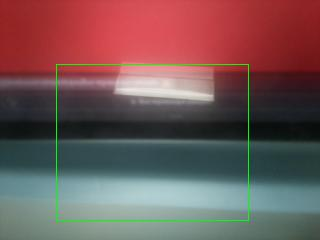

picamera session ended
triggered image processing thread


In [6]:
frames = queue.Queue(maxsize = 10)
thread_stopper = threading.Event()
lock = threading.Lock()
target_color = np.array([255, 255, 255]) # white
border_color = np.array([0, 255, 0]) # green
color_threshold = 0.07 # in percentage
time_to_run = 30 # in seconds

start = time.time()
imageThread = ImageProcessor(thread_stopper, frames, lock)
imageThread.start()

with picamera.PiCamera() as camera:
    camera.resolution = (320, 240)
    camera.framerate = 30
    while time.time() - start < time_to_run:
        freshest_frame = np.empty((240, 320, 3), dtype = np.uint8)
        camera.capture_sequence([freshest_frame], use_video_port = True, format = 'rgb')
        lock.acquire()
        if frames.full():
            frames.get()
            frames.task_done()
        else:
            frames.put(freshest_frame)
        lock.release()
print("picamera session ended")

thread_stopper.set()
print("triggered image processing thread")

# imageThread.join()
# print("thread joined")